In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [2]:
def softmax(x):
    z = x - np.max(x)   # overflow protection (softmax(x) = softmax(x - const))
    return np.exp(z) / np.sum(np.exp(z))

activation_functions = {
    'tanh': tf.tanh,
    'relu': (lambda x: tf.maximum(0, x)),
    'sigmoid': (lambda x: 1 / (1 + tf.exp(-x))),
    'linear': (lambda x: x),
    'softmax': tf.nn.softmax
}

**Loading Data**

In [3]:
%%time
t0 = time.time()
# numpy
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, np.shape(X_train)[1] * np.shape(X_train)[1]).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, np.shape(X_test)[1] * np.shape(X_test)[1]).astype(np.float32) / 255.0

y_train = to_categorical(y_train)   # one-hot encoding
y_test = to_categorical(y_test)  # one-hot encoding

# tensorflow
X = tf.convert_to_tensor(np.transpose(X_test))
Y = tf.convert_to_tensor(np.transpose(y_test))

CPU times: total: 344 ms
Wall time: 352 ms


**Network Definition**

In [4]:
MUTATE_RATE_MATRIX = 0.3
MUTATE_RATE_BIAS = 0.1
MUTATE_RATE_ACTIVATION_FUNCTION = 0.1
GAUSSIAN_NOISE_STDDEV = 1

In [5]:
def bitstring_mutation(param, mutate_rate, n_bits=7):
    try:
        # TODO: check if correct (esp. sign)
        bitstring = bin(param)[2:].zfill(param)
        temp = ''
        sign = +1 if random.uniform(0, 1) else -1
        for i in range(len(bitstring)):
            if random.uniform(0, 1) < mutate_rate:
                temp2 = '0' if bitstring[i] == '1' else '1'
                temp += temp2
            else:
                temp += bitstring[i]
        return sign * int(temp, 2)

    except (TypeError):
        bitstring = bin(param)[2:].zfill(param)
        temp = ''
        sign = +1 if random.uniform(0, 1) else -1
        for i in range(len(bitstring)):
            if random.uniform(0, 1) < mutate_rate:
                temp2 = '0' if bitstring[i] == '1' else '1'
                temp += temp2
            else:
                temp += bitstring[i]
        print(param, temp)

In [6]:
class MultiLayerPerceptron(Model):
    # TODO: variable layers
    def __init__(self, matrix1, bias1, activation1, matrix2, bias2, activation2):
        super(MultiLayerPerceptron, self).__init__()

        self.matrix1 = matrix1
        self.bias1 = bias1
        self.activation1 = activation1

        self.matrix2 = matrix2
        self.bias2 = bias2
        self.activation2 = activation2

    def call(self, input):
        x = self.matrix1 @ input
        x += self.bias1
        x = activation_functions[self.activation1](x)

        x = self.matrix2 @ x
        x += self.bias2
        x = activation_functions[self.activation2](x)

        return x

    def evaluate(self):
        y_pred = np.argmax(self.call(X), axis=0)
        y_true = np.argmax(Y, axis=0)
        return np.mean(y_pred == y_true)

    def mutate(self):
        # TODO: quite arbitrary, inefficient and do negative numbers work?
        # TODO: only works for integers as of now

        # connectivity matrix
        for matrix_name in ('matrix1', 'matrix2'):
            matrix = getattr(self, matrix_name)
            # TODO: clamp to min, max?
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_MATRIX, MUTATE_RATE_MATRIX]]),
                matrix.shape[0] * matrix.shape[1]), matrix.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=matrix.shape)  # TODO: tune stddev
            matrix = matrix + tf.multiply(mutation_stencil, noise)
            setattr(self, matrix_name, matrix)
            '''for row in range(matrix.shape[0]):
                for col in range(matrix.shape[1]):
                    if random.uniform(0, 1) < MUTATE_RATE_MATRIX:
                        matrix[row][col] = bitstring_mutation(matrix[row][col], MUTATE_RATE_MATRIX, n_bits=7)'''

        # bias
        for bias_name in ('bias1', 'bias2'):
            bias = getattr(self, bias_name)
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_BIAS, MUTATE_RATE_BIAS]]),
                bias.shape[0] * bias.shape[1]), bias.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=bias.shape)  # TODO: tune stddev
            bias = bias + tf.multiply(mutation_stencil, noise)
            setattr(self, bias_name, bias)
            '''bias = bitstring_mutation(bias, MUTATE_RATE_BIAS, n_bits=7)'''

        # activation function
        # TODO: keep softmax at the end?
        for activation_name in ('activation1'):
            if random.uniform(0, 1) < MUTATE_RATE_ACTIVATION_FUNCTION:
                activation = random.choice(list(activation_functions.keys()))
                setattr(self, activation_name, activation)

In [10]:
class Population():
    def __init__(self, size=10, n_survivors=5):
        self.generation = 0
        self.size = size
        self.n_survivors = n_survivors
        self.elite = None
        self.fitness = None
        self.fitness_generation = -1  # generation when fitness was evaluated

        # initialization (gaussian)
        # TODO: max, min for now 7-bit integers
        self.organisms = []
        for _ in range(size):
            # TODO: for now fixed architecture
            bias1 = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 1])
            matrix1 = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 784])
            activation1 = 'sigmoid'

            bias2 = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, 1])
            matrix2 = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, 32])
            activation2 = 'softmax'

            model = MultiLayerPerceptron(matrix1, bias1, activation1, matrix2, bias2, activation2)
            model.compile()

            self.organisms.append(model)

        self.history = [(max(self.organism_fitness()), self.average_fitness())]   # fitness of population over all generations

    def organism_fitness(self):
        if self.generation != self.fitness_generation:
            self.fitness = [organism.evaluate() for organism in self.organisms]
            self.fitness_generation = self.generation

        return self.fitness

    def average_fitness(self):
        organism_fitness = self.organism_fitness()
        return sum(organism_fitness) / len(organism_fitness)

    def max_fitness(self):
        return max(self.organism_fitness())

    def selection(self):
        organism_fitness = self.organism_fitness()

        # elitism (n=1)
        elite_index = np.argmax(organism_fitness)
        self.elite = self.organisms.pop(elite_index)
        organism_fitness.pop(elite_index)

        probabilities = [fitness / sum(organism_fitness) for fitness in organism_fitness]  # normalized
        survivors = np.random.choice(self.organisms,
                                     size=self.n_survivors - 1,
                                     p=probabilities,
                                     replace=False)    # TODO: works without replacement and p?
        return [survivor for survivor in survivors]

    def crossover(self, parents):
        # TODO: for different type of networks
        # TODO: correct?
        children = []
        while len(children) < (self.size - 1):
            [father, mother] = random.sample(parents + [self.elite], k=2)  # sample without replacement

            # TODO: for now assume same no of layers
            # TODO: create new model - efficient?

            # bias, activation function (full gene crossover) # TODO: good?
            child_bias1 = father.bias1 if (random.uniform(0, 1) < 0.5) else mother.bias1
            child_bias2 = father.bias2 if (random.uniform(0, 1) < 0.5) else mother.bias2

            child_activation1 = father.activation1 if (random.uniform(0, 1) < 0.5) else mother.activation1
            child_activation2 = father.activation2 if (random.uniform(0, 1) < 0.5) else mother.activation2

            # matrix (uniform (bit-wise) crossover) # TODO: good?
            father_stencil = tf.round(tf.random.uniform(father.matrix1.shape))
            mother_stencil = - (father_stencil - 1)
            child_matrix1 = tf.multiply(father_stencil, father.matrix1) + tf.multiply(mother_stencil, mother.matrix1)

            father_stencil = tf.round(tf.random.uniform(father.matrix2.shape))
            mother_stencil = - (father_stencil - 1)
            child_matrix2 = tf.multiply(father_stencil, father.matrix2) + tf.multiply(mother_stencil, mother.matrix2)

            model = MultiLayerPerceptron(child_matrix1,
                                         child_bias1,
                                         child_activation1,
                                         child_matrix2,
                                         child_bias2,
                                         child_activation2)
            model.compile() # TODO: necessary??
            children.append(model)

        return children

    def mutate(self, organisms):
        for organism in organisms:
            organism.mutate()

    def breed(self):
        #time_debug = ''

        #t_a = time.time()
        parents = self.selection()
        #t_b = time.time()
        #time_debug += 'selection time: {}s - '.format(round(t_b - t_a, 4))

        #t_a = time.time()
        children = self.crossover(parents)
        #t_b = time.time()
        #time_debug += 'crossover time: {}s - '.format(round(t_b - t_a, 4))

        #t_a = time.time()
        self.mutate(children)  # TODO: mGA or GA?
        #t_b = time.time()
        #time_debug += 'mutation time: {}s - '.format(round(t_b - t_a, 4))

        #print(time_debug)

        self.organisms = children + [self.elite]
        self.generation += 1
        self.history.append((self.max_fitness(), self.average_fitness()))

    def plot(self):
        plt.figure()
        plt.plot(np.arange(self.generation + 1), [score[0] for score in self.history],
                 label='max fitness')
        plt.plot(np.arange(self.generation + 1), [score[1] for score in self.history],
                 label='avg fitness', alpha=0.6)
        plt.title('Population fitness' + ' (n=' + str(self.size) + ')')
        plt.xlabel('Generations')
        plt.ylabel('Fitness score (accuracy)')
        plt.legend()
        plt.show()

**Training**

In [13]:
# initialization
GENERATIONS = 400
POPULATION_SIZE = 30
SURVIVORS = 5

Starting training
Gen 0 : [0.1525, 0.087, 0.0861, 0.1096, 0.1126, 0.1084, 0.0705, 0.1209, 0.073, 0.1235, 0.1259, 0.0894, 0.0873, 0.1085, 0.1112, 0.1347, 0.105, 0.1063, 0.1369, 0.1171, 0.1042, 0.0741, 0.1397, 0.065, 0.0895, 0.1045, 0.0845, 0.1118, 0.0818, 0.1035] - max: 0.1525 (0.4s)
Gen 1 : [0.0678, 0.1213, 0.0692, 0.1102, 0.0883, 0.1032, 0.1196, 0.0748, 0.0875, 0.0769, 0.0918, 0.0798, 0.0967, 0.102, 0.1378, 0.0995, 0.0689, 0.1291, 0.1096, 0.1193, 0.0935, 0.0985, 0.1151, 0.1096, 0.1401, 0.0684, 0.1011, 0.0776, 0.109, 0.1525] - max: 0.1525 (0.53s)
Gen 2 : [0.0813, 0.1073, 0.0851, 0.1208, 0.1137, 0.1093, 0.1139, 0.1288, 0.0864, 0.1038, 0.1028, 0.1192, 0.0955, 0.0903, 0.1078, 0.128, 0.0814, 0.1163, 0.1289, 0.0966, 0.1458, 0.131, 0.102, 0.0718, 0.1306, 0.0973, 0.0767, 0.0689, 0.0994, 0.1525] - max: 0.1525 (0.64s)
Gen 3 : [0.0934, 0.1379, 0.0818, 0.1167, 0.0869, 0.1148, 0.1003, 0.1058, 0.1259, 0.091, 0.0927, 0.0756, 0.1494, 0.1105, 0.1207, 0.1108, 0.0969, 0.1348, 0.1036, 0.098, 0.1167, 0.12

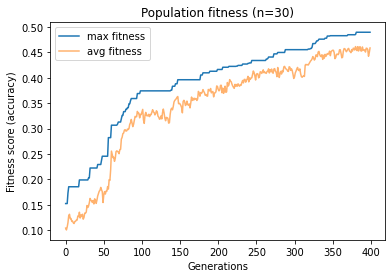

In [14]:
# initial population
print('Starting training')
t_training = time.time()
population = Population(size=POPULATION_SIZE, n_survivors=SURVIVORS)
population_fitness = population.organism_fitness()
max_fitness = population.max_fitness()
t2 = time.time()
print('Gen', 0, ':',
      population_fitness, '- max:',
      max_fitness,
      '({}s)'.format(round(t2 - t_training, 2)))

# future populations
for generation in range(1, GENERATIONS):
    # breed new population
    t1 = time.time()
    population.breed()

    # evaluate new population
    population_fitness = population.organism_fitness()
    max_fitness = population.max_fitness()
    t2 = time.time()

    print('Gen', generation, ':',
          population_fitness, '- max:',
          max_fitness,
          '({}s)'.format(round(t2 - t1, 2)))

print('Finished training ({})'.format(round(time.time() - t_training, 2)))
print('\nTotal computation time: ({}s)'.format(round(time.time() - t0, 2)))

# performance of population
population.plot()